The goal of this project is to build a system for retrieving relevant reviews based on user queries for the Harry Potter movie. The dataset is a 491-entries table with 8 columns taken from Kaggle. We’ll use neural networks, specifically Convolutional Neural Networks (CNNs), for text classification, retrieval and ranking.

# CNN for text classification

## Import dataset and libraries

In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Embedding, Dropout
from keras.regularizers import l2
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Load dataset
harry_potter_reviews = pd.read_csv("harry_potter_reviews.csv")

# Inspect dataset
print(harry_potter_reviews.head())

   user_id user_sex  user_age user_country  rating  \
0        0   female        50      Germany     2.5   
1        1   female        23        Spain     4.0   
2        2     male        32       France     3.0   
3        3   female        24       Turkey     4.5   
4        4   female        40        Spain     5.0   

                                             comment favourite_character  \
0  "The transitions between scenes were awkward, ...       Severus Snape   
1   "Severus Snape's role adds an intriguing layer."       Severus Snape   
2  "The pacing was a bit slow, but the characters...         Ron Weasley   
3  "Hagrid's love for magical creatures is heartw...       Rubeus Hagrid   
4   "Neville Longbottom's courage is awe-inspiring."  Neville Longbottom   

         date  
0  2004-12-27  
1  2003-11-22  
2  2005-09-16  
3  2002-09-17  
4  2004-10-17  


## Preprocessing

In [3]:
# Tokenize the text and convert it into sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(harry_potter_reviews['comment'])
X = tokenizer.texts_to_sequences(harry_potter_reviews['comment'])
# Pad sequences to ensure uniform length
X = pad_sequences(X)
# Encode target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(harry_potter_reviews['favourite_character'])

## Model creation function and K-fold cross-validation

In [14]:
# Model creation function
def create_model():
    '''
    Function to create a Convolutional Neural Network (CNN) model
    '''
    # Define CNN architecture
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=200))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))
    model.add(Dropout(0.3))  # Added Dropout layer
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# K-fold cross-validation
k_fold = 5
kf = KFold(n_splits=k_fold)

# Empty list for the cv scores
cv_scores = []

for train_index, test_index in kf.split(X):
    # Split data into training and testing sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Create and train the model
    model = create_model()
    model.fit(X_train, y_train, epochs=8, batch_size=32, verbose=0)  # verbose=0 to suppress training output
    # Evaluate the model
    score = model.evaluate(X_test, y_test, verbose=0)
    cv_scores.append(score[1])

print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", np.mean(cv_scores))

Cross-validation scores: [0.6666666865348816, 0.704081654548645, 0.795918345451355, 0.704081654548645, 0.7857142686843872]
Mean CV accuracy: 0.7312925219535827


## Predictions

In [15]:
# Get the model predictions on the dataset
predictions = model.predict(X)
predicted_classes = predictions.argmax(axis=-1)
# Decode the predicted classes
predicted_labels = label_encoder.inverse_transform(predicted_classes)
print(classification_report(y, predicted_classes, target_names=label_encoder.classes_))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
                    precision    recall  f1-score   support

  Albus Dumbledore       0.91      0.78      0.84        50
      Draco Malfoy       0.98      0.98      0.98        46
      Harry Potter       0.76      0.88      0.82        73
  Hermione Granger       0.80      0.97      0.88        78
Neville Longbottom       1.00      0.81      0.89        52
       Ron Weasley       0.92      0.92      0.92        79
     Rubeus Hagrid       0.96      0.83      0.89        63
     Severus Snape       1.00      0.96      0.98        50

          accuracy                           0.89       491
         macro avg       0.92      0.89      0.90       491
      weighted avg       0.90      0.89      0.89       491



## Confusion Matrix

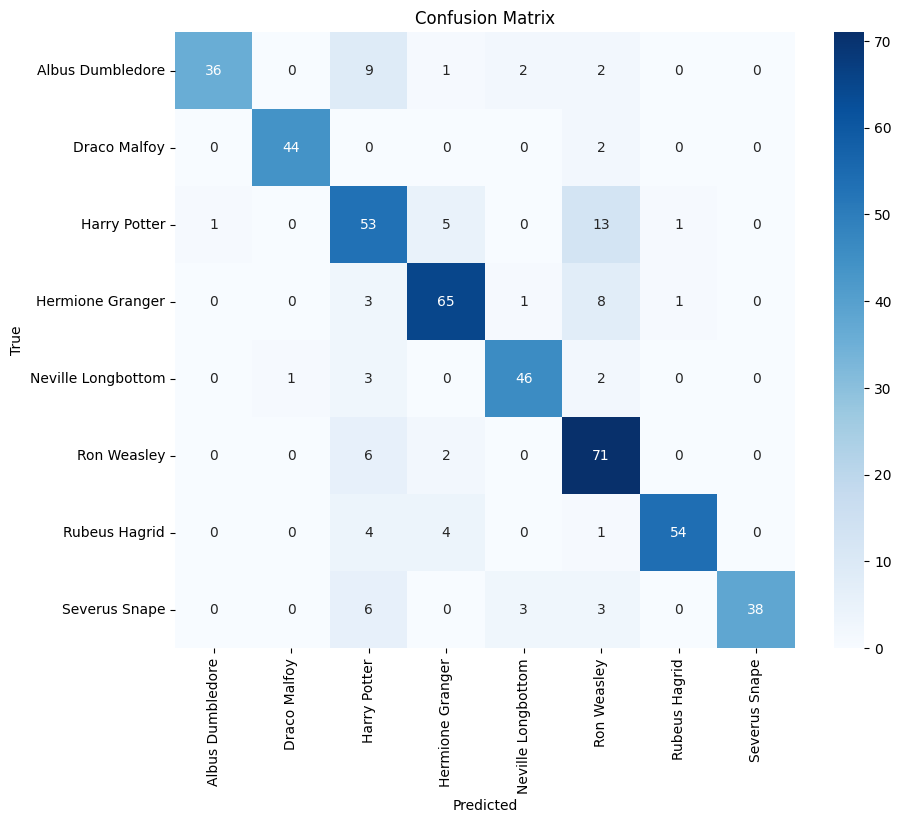

In [6]:
conf_matrix = confusion_matrix(y, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Mean metrics

In [7]:
# Mean metrics calculation
mean_f1_score = f1_score(y, predicted_classes, average='weighted')
mean_precision = precision_score(y, predicted_classes, average='weighted')
mean_recall = recall_score(y, predicted_classes, average='weighted')
print("Mean F1-score:", mean_f1_score)
print("Mean Precision:", mean_precision)
print("Mean Recall:", mean_recall)

Mean F1-score: 0.8328003975425968
Mean Precision: 0.8498376826039459
Mean Recall: 0.8289205702647657


# Queries

## Preprocessing for query and query answer

In [10]:
# Define the query
query = "Draco Malfoy is not an interesting character."

# Tokenize and pad the query sequence to match the input shape of the model
query_sequence = tokenizer.texts_to_sequences([query])
query_padded = pad_sequences(query_sequence, maxlen=X.shape[1])

# Obtain the embedding for the query using the trained model
query_embedding = model.predict(query_padded)

# Compute cosine similarity between the query embedding and embeddings of all reviews in the dataset
similarities = cosine_similarity(query_embedding, model.predict(X))

# Find the index of the most similar review
most_similar_index = similarities.flatten().argsort()[-1]

# Retrieve the most similar review from the dataset
most_similar_review = harry_potter_reviews['comment'].iloc[most_similar_index]

print("Most similar review:", most_similar_review)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Most similar review: "Charm and wit make Draco Malfoy memorable."


## Ranking of reviews with CNN

In [12]:
# Set maximum length for padded reviews
max_length = 200

def get_reviews_ranking_custom(query, harry_potter_reviews, model, tokenizer):
    '''
    Function to rank reviews based on a query using a CNN model
    '''
    # Tokenize and filter stopwords for query
    tokenized_query = word_tokenize(query)
    stop_words = set(stopwords.words('english'))
    filtered_query = [word for word in tokenized_query if word.lower() not in stop_words]
    query_text = ' '.join(filtered_query)
    
    # Get all reviews from the dataset and append the query
    all_reviews = harry_potter_reviews['comment'].tolist()
    all_reviews.append(query_text)
    
    # Encode and pad all reviews
    encoded_reviews = tokenizer.texts_to_sequences(all_reviews)
    padded_reviews = pad_sequences(encoded_reviews, maxlen=max_length, padding='post')
    
    # Obtain embeddings for all reviews
    review_embeddings = model.predict(padded_reviews)
    
    # Separate query embedding from the rest
    query_embedding = review_embeddings[-1]
    review_embeddings = review_embeddings[:-1]
    
    # Compute cosine similarity between query embedding and all review embeddings
    similarities = cosine_similarity(query_embedding.reshape(1, -1), review_embeddings)[0]
    
    # Rank reviews based on similarity scores
    ranking_indices = np.argsort(similarities)[::-1]
    reviews_ranking = harry_potter_reviews.iloc[ranking_indices]
    
    return reviews_ranking

# Your query
your_query = "hermione's smartness is well-represented."

# Get ranking of reviews for your query
ranking = get_reviews_ranking_custom(your_query, harry_potter_reviews, model, tokenizer)

# Print the ranking of reviews
print("Ranking of reviews for your query:", ranking['comment'])

# Save ranking to CSV file
output_file = "ranking_results.csv"
ranking.to_csv(output_file, index=False)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Ranking of reviews for your query: 22     "The world-building is intricate and captivati...
452    "The soundtrack adds an enchanting touch to th...
412    "The adaptation deviates too much from the sou...
458       "The soundtrack failed to evoke any emotions."
289                 "The cinematography is outstanding."
                             ...                        
365    "Albus Dumbledore's wisdom feels clichéd and u...
61     "Albus Dumbledore's wisdom feels clichéd and u...
204    "The wisdom and leadership of Albus Dumbledore...
409    "The portrayal of Severus Snape's character wa...
366    "The complexity of Severus Snape's character a...
Name: comment, Length: 491, dtype: object
